In [1]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets

from datasets.text2shape import  Text2Shape





import cv2
import numpy as np
import imageio
from PIL import Image
from einops import rearrange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from pytorch3d import structures

from utils.util_3d import sdf_to_mesh, render_mesh, rotate_mesh_360


from datasets.text2shape import  Text2Shape


%reload_ext autoreload
%autoreload 2

In [9]:
seed_everything(111)

description = "BertV9/TransV5/withProbs"
res_dir = 'logs/july-12/t3-withprobs'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [3]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=1
    max_dataset_size=10000000

    name='test_transformer'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.seed = 111
    opt.isTrain = False
    opt.gpu_ids = gpuid
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size

    opt.name = name

    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    return opt




def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model



In [4]:

class Opt:
    def __init__(self):
        self.name = 'opt'

gpu_id=0
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path_V1 = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
new_checkpoint_path_V2="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
new_checkpoint_path_V3 = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
new_checkpoint_path_V5 = "../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth"


modelV0 = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
modelV0.eval()
modelV5 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V5)
modelV5.eval()





[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth


/rhome/streakfull/.cache/pypoetry/virtualenvs/adl4cv-I-Koul65-py3.8/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints/rand_tf_singles_best.pth
MODEL LOADED
[*] "rand_tf_old" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints/rand_tf_singles_best.pth
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth


In [5]:
""" setup renderer """
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)
def load_bert2vqsc_model_v9(opt):
    from models.networks.bert2vq_sc_v4 import BERT2VQ
    
    net = BERT2VQ(opt)
    # bert2vq_ckpt = '/home/paritosh/Desktop/Capstone/clean-code/generative_transformers/logs/bert2vq-shapenet_lang-all-LR1e-4-cleanCode-langMode-/ckpt/bert2vq_epoch-145.pth'
    #bert2vq_ckpt = '../raw_dataset/checkpoints/bert2vq_epoch-latest.pth'
    #bert2vq_ckpt = "../raw_dataset/checkpoints_plz/bert2vq_v2.pth"
    bert2vq_ckpt = "../raw_dataset/checkpoints_new/plzFInal.pth"
    state_dict = torch.load(bert2vq_ckpt)
    net.load_state_dict(state_dict['bert2vq'])
    net.eval()
    net.to(opt.device)
    
    return net

bert2vqV9 = load_bert2vqsc_model_v9(opt)

In [6]:
dataset = Text2Shape()
#opt = Opt()

dataset.initialize(opt,isTrain=True)
len(dataset)

140707

  0%|                                                                          | 0/50 [00:00<?, ?it/s]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-0-0-light blue color chair.gif
light blue color chair


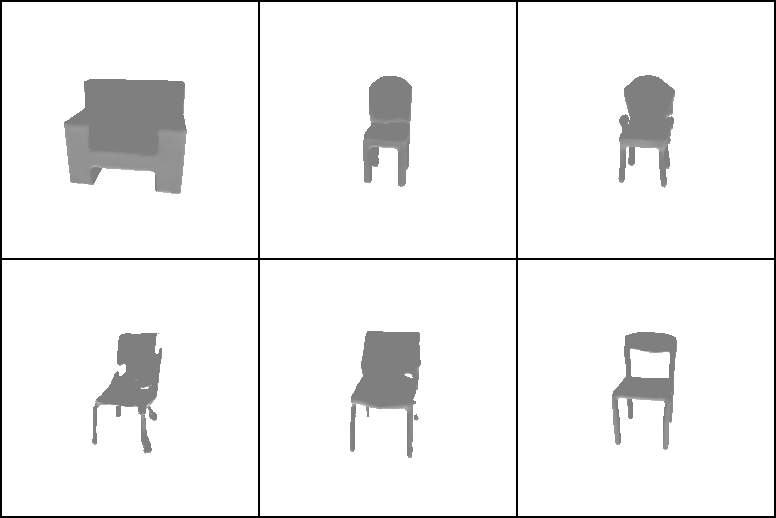

  2%|█▎                                                                | 1/50 [00:06<05:16,  6.45s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-1-0-a pale blue chair.gif
a pale blue chair


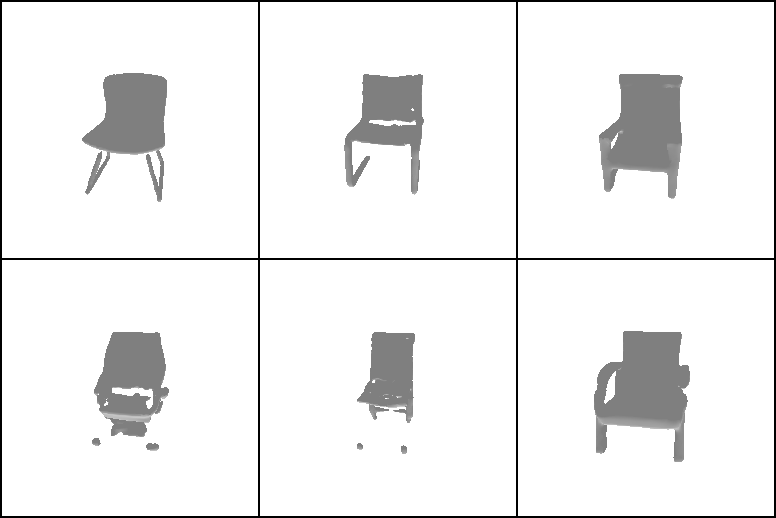

  4%|██▋                                                               | 2/50 [00:12<05:09,  6.45s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-2-0-with slim legs.gif
with slim legs


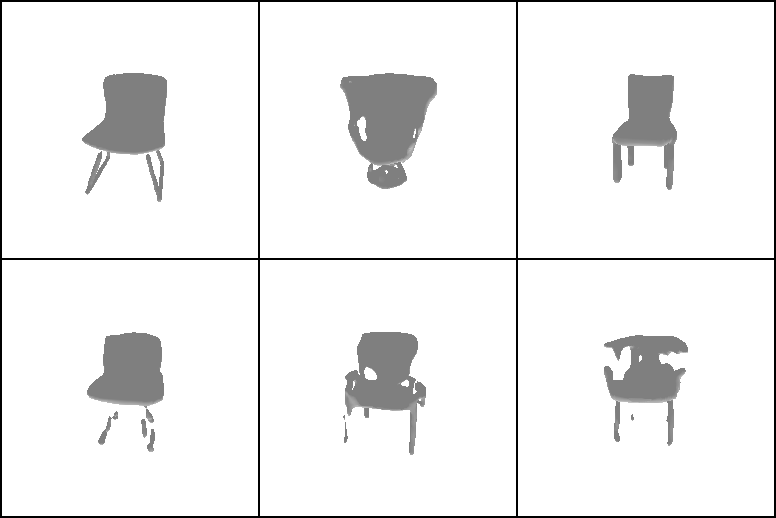

  6%|███▉                                                              | 3/50 [00:19<05:02,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/3-1-and grey and black checkers.gif
and grey and black checkers


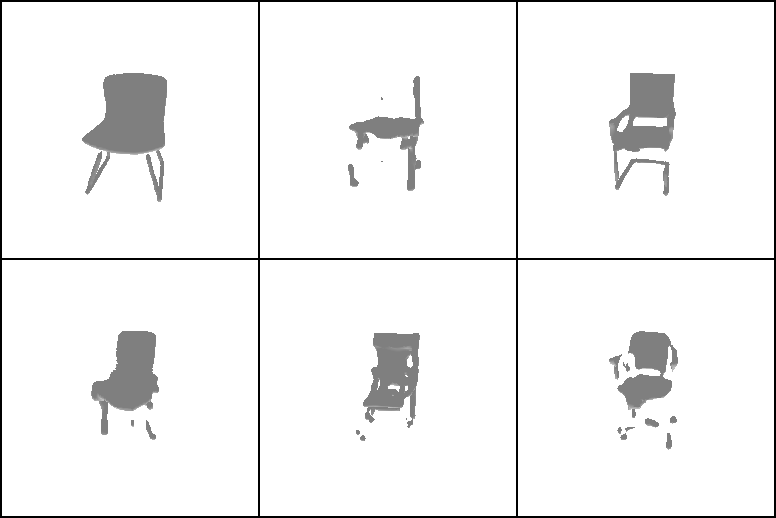

  8%|█████▎                                                            | 4/50 [00:25<04:54,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/4-2-a pale blue chair with slim legs and grey and black checkers on the back.gif
a pale blue chair with slim legs and grey and black checkers on the back


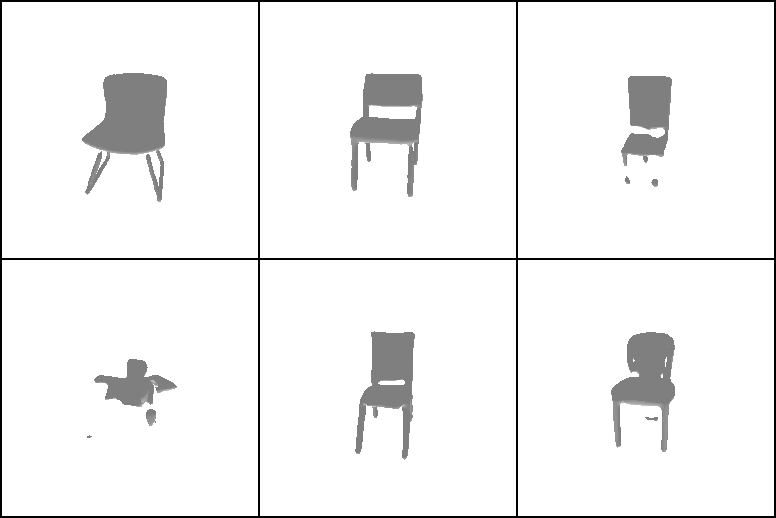

 10%|██████▌                                                           | 5/50 [00:32<04:48,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/5-3-with no hand rests.gif
with no hand rests


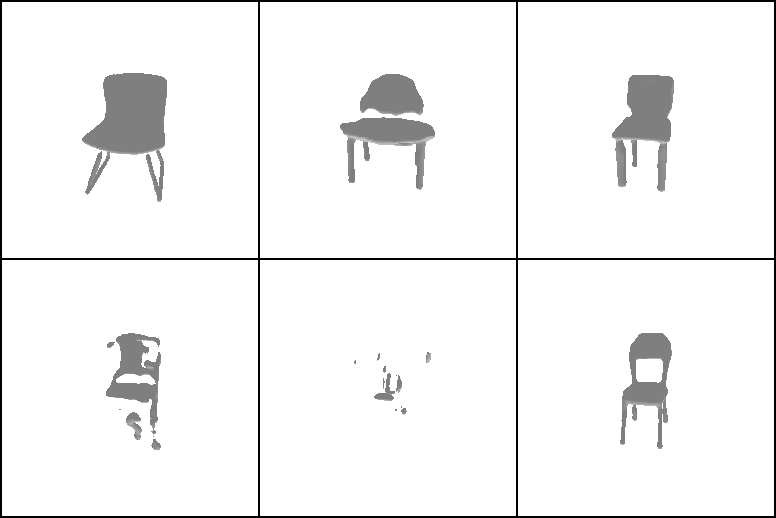

 12%|███████▉                                                          | 6/50 [00:38<04:41,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-6-0-A smooth base curved shaped chair.gif
A smooth base curved shaped chair


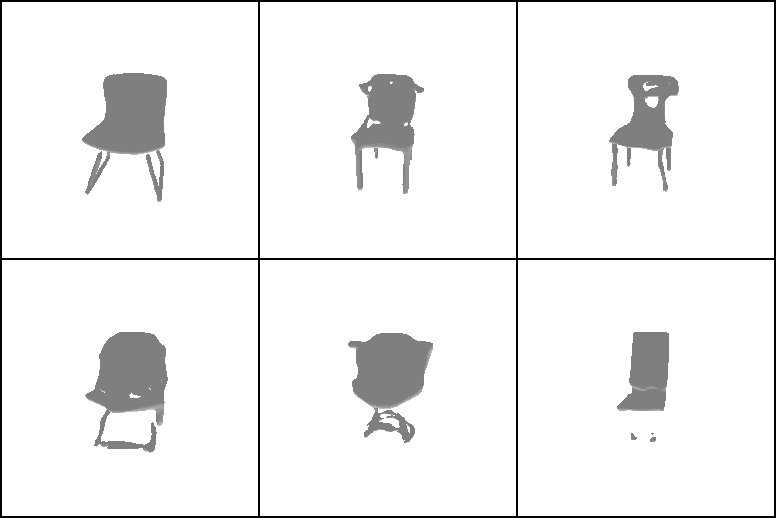

 14%|█████████▏                                                        | 7/50 [00:44<04:35,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-7-0-with no arm rest.gif
with no arm rest


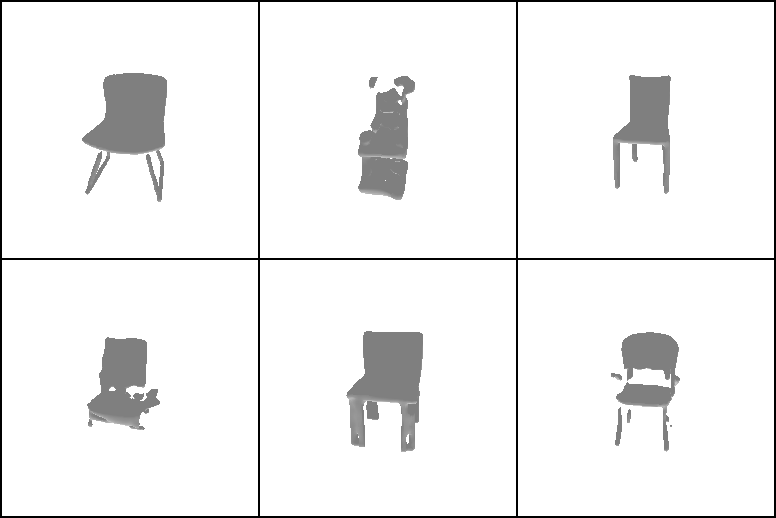

 16%|██████████▌                                                       | 8/50 [00:51<04:29,  6.42s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-8-0-IT HAS FOUR LEGS ..gif
IT HAS FOUR LEGS .


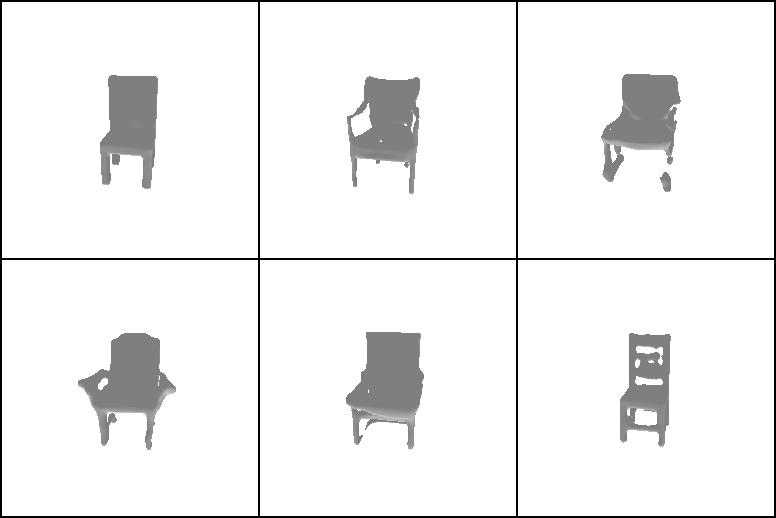

 18%|███████████▉                                                      | 9/50 [00:57<04:24,  6.44s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-9-0-YOU CAN SIT IN IT.gif
YOU CAN SIT IN IT


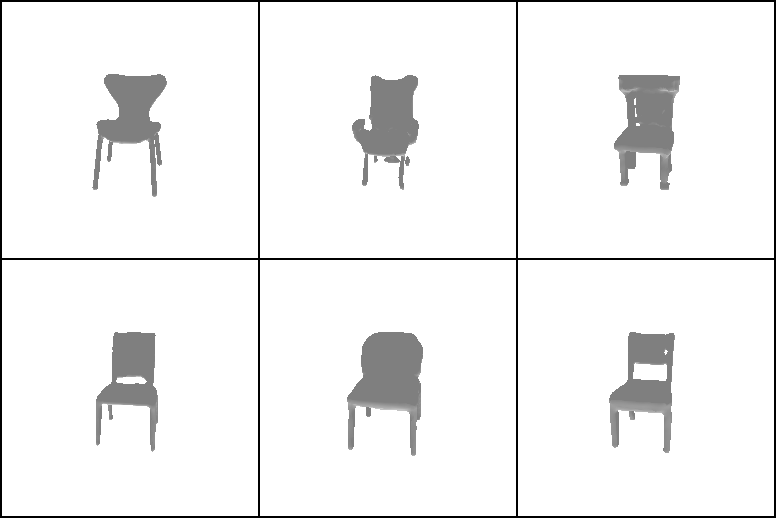

 20%|█████████████                                                    | 10/50 [01:04<04:17,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-10-0-YOU CAN SIT IN IT.gif
YOU CAN SIT IN IT


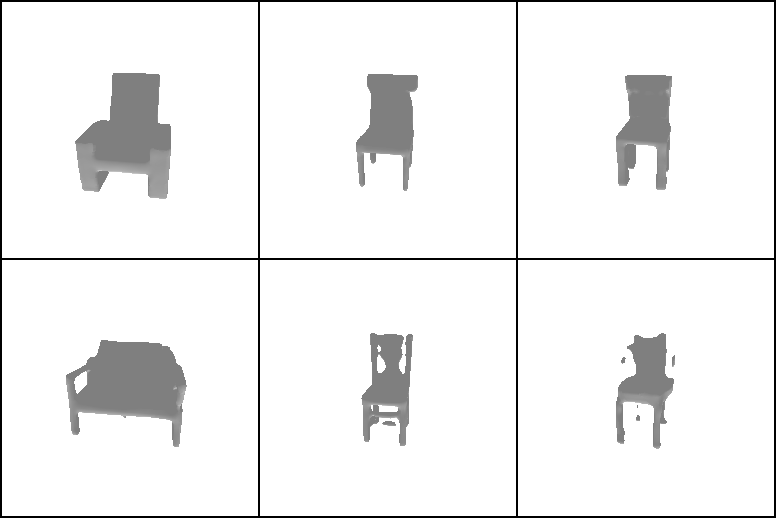

 22%|██████████████▎                                                  | 11/50 [01:10<04:10,  6.42s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-11-0-IT HAS FOUR LEGS.gif
IT HAS FOUR LEGS


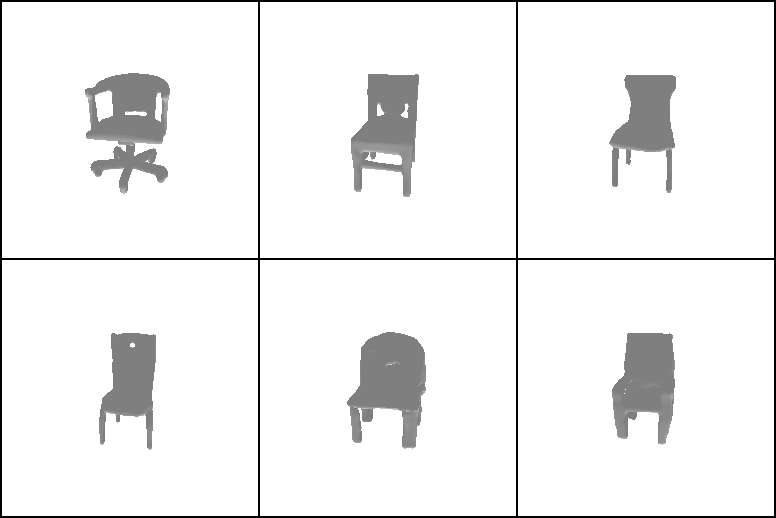

 24%|███████████████▌                                                 | 12/50 [01:17<04:03,  6.42s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-12-0-A modern gray colored chair.gif
A modern gray colored chair


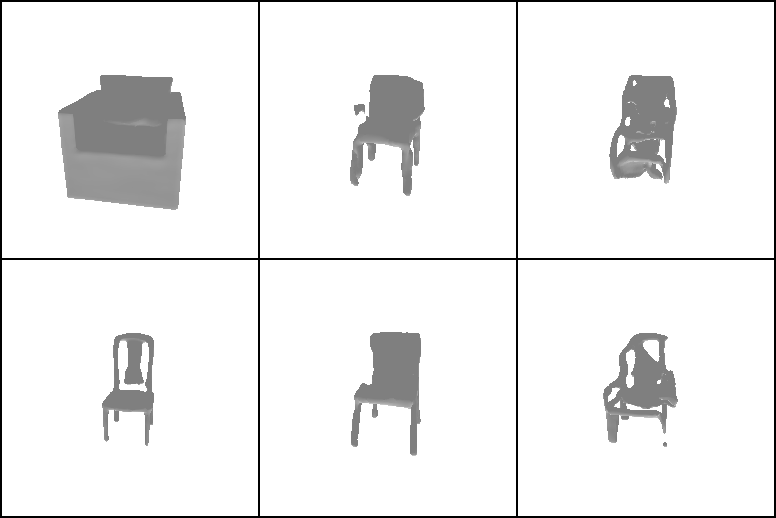

 26%|████████████████▉                                                | 13/50 [01:23<03:58,  6.44s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-13-0-with thin legs.gif
with thin legs


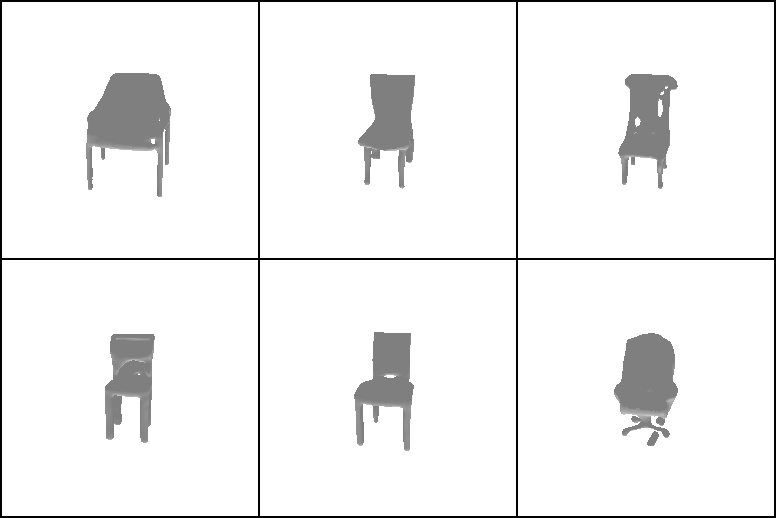

 28%|██████████████████▏                                              | 14/50 [01:29<03:51,  6.42s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/14-1-and without hands.gif
and without hands


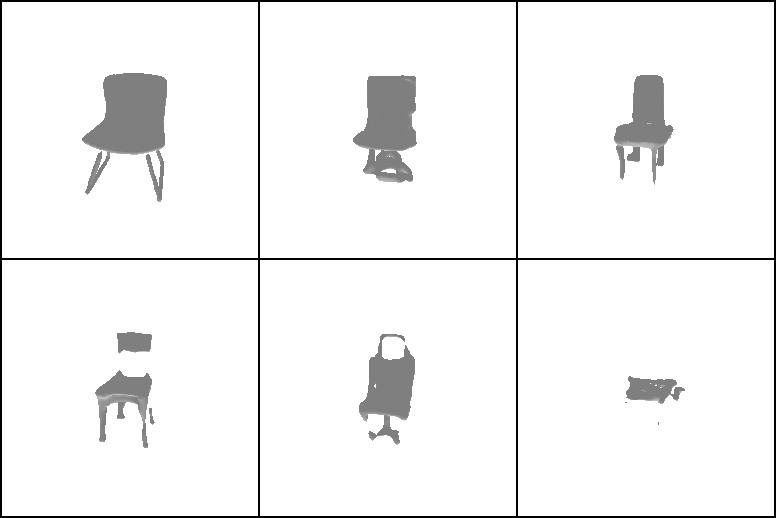

 30%|███████████████████▌                                             | 15/50 [01:36<03:44,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-15-0-brown , chair.gif
brown , chair


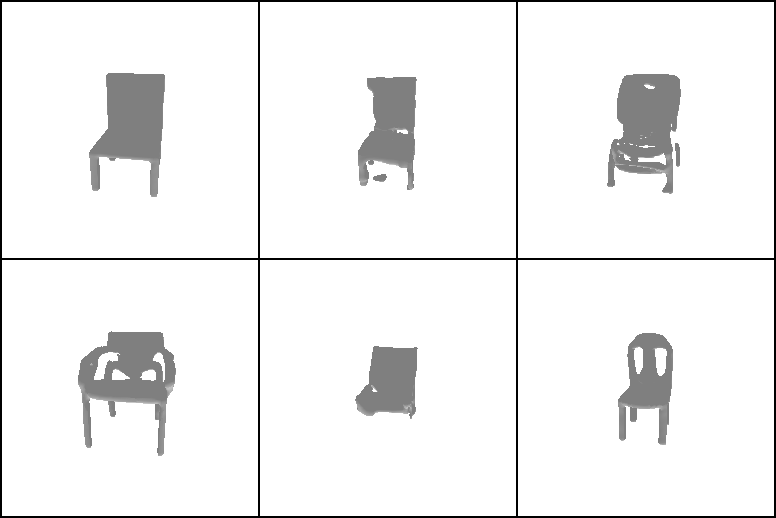

 32%|████████████████████▊                                            | 16/50 [01:42<03:37,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-16-0-with 8 poles.gif
with 8 poles


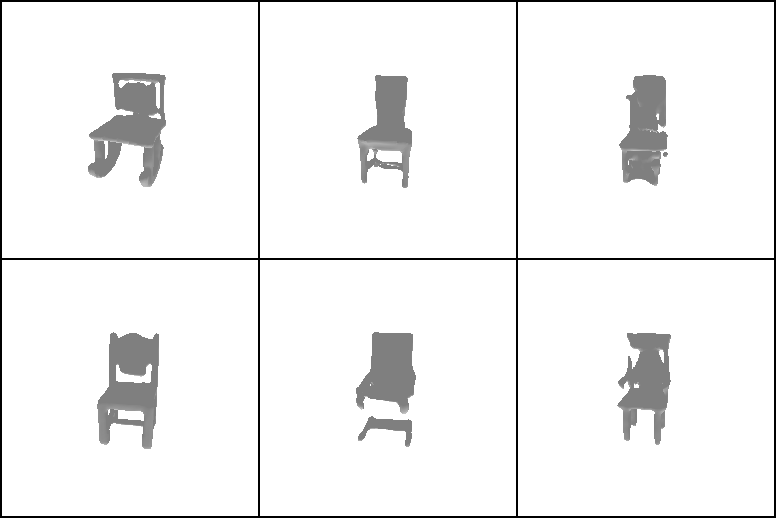

 34%|██████████████████████                                           | 17/50 [01:49<03:31,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/17-1-and rocking feet.gif
and rocking feet


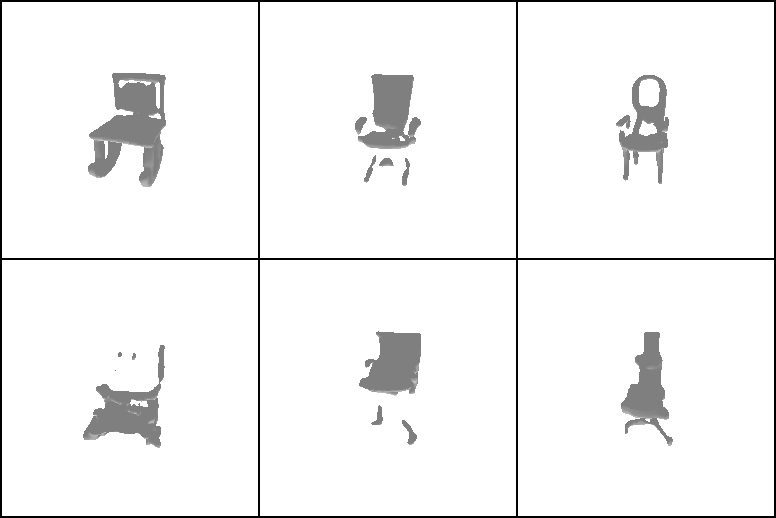

 36%|███████████████████████▍                                         | 18/50 [01:55<03:24,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-18-0-an old style brown wooden chair.gif
an old style brown wooden chair


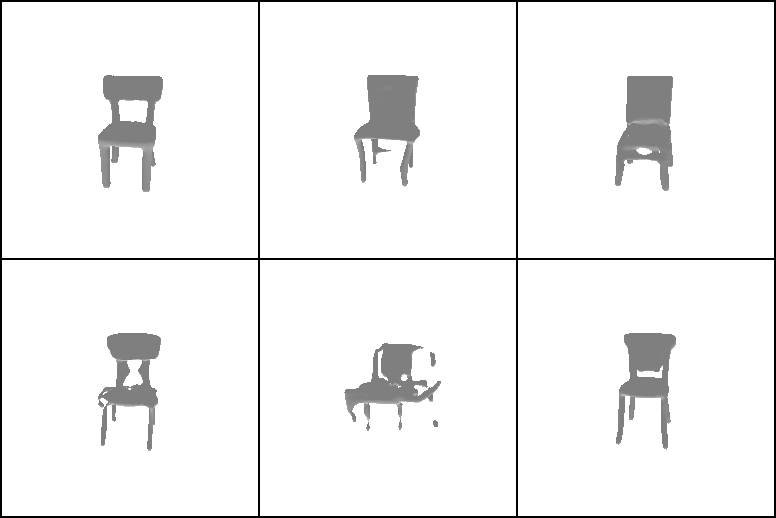

 38%|████████████████████████▋                                        | 19/50 [02:01<03:18,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-19-0-with curved back.gif
with curved back


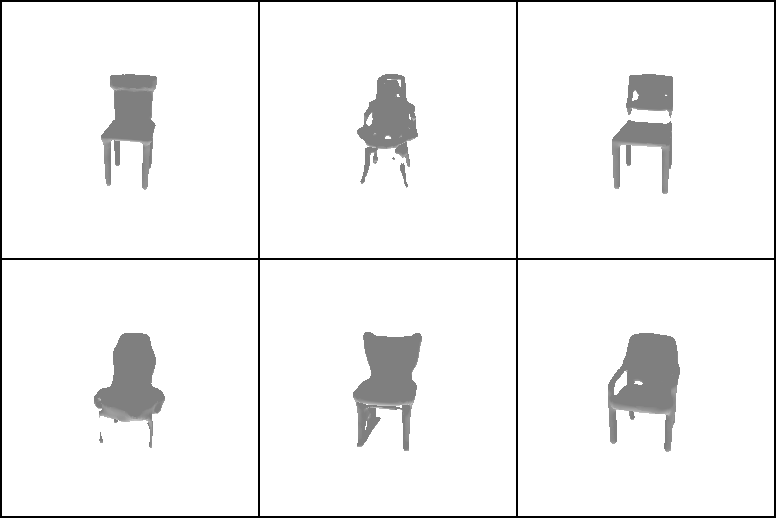

 40%|██████████████████████████                                       | 20/50 [02:08<03:11,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/20-1-and curved legs.gif
and curved legs


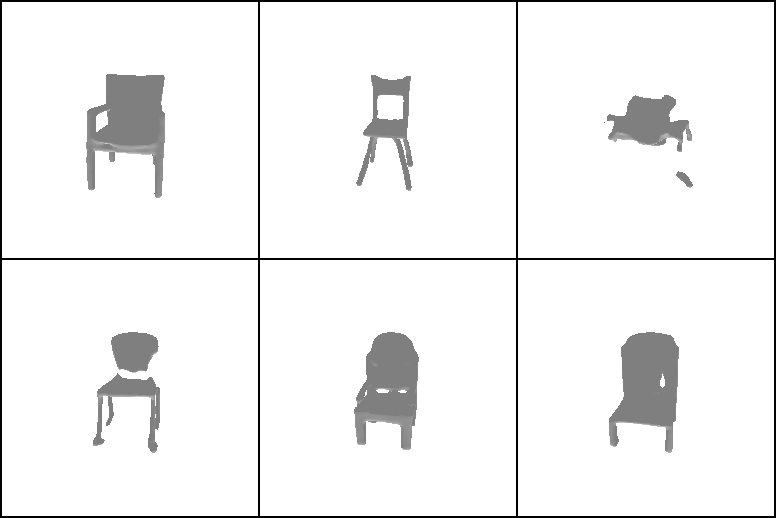

 42%|███████████████████████████▎                                     | 21/50 [02:14<03:05,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-21-0-with 2 wooden legs.gif
with 2 wooden legs


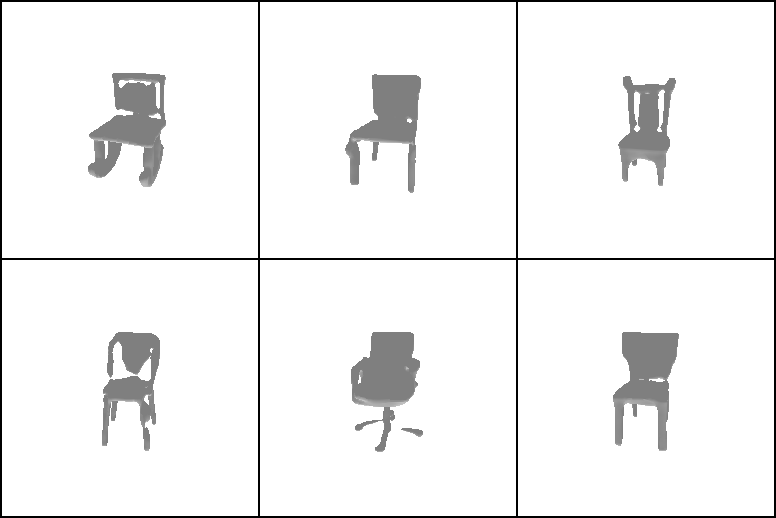

 44%|████████████████████████████▌                                    | 22/50 [02:20<02:58,  6.37s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/22-1-and bamboo back support.gif
and bamboo back support


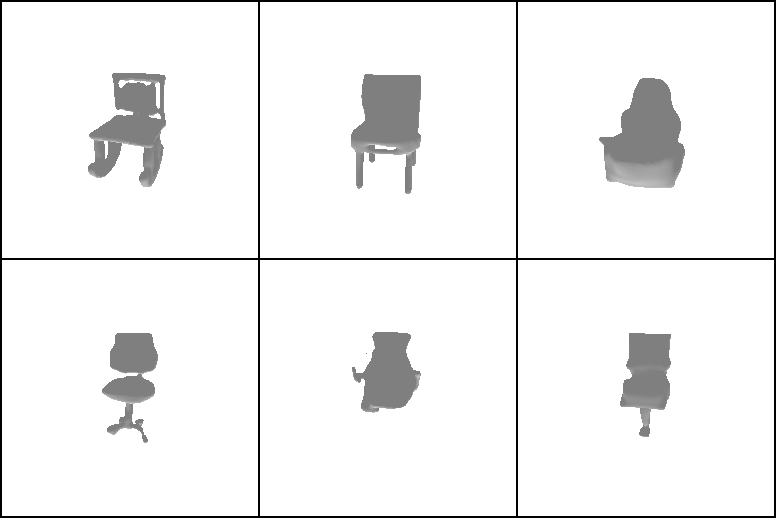

 46%|█████████████████████████████▉                                   | 23/50 [02:27<02:52,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-23-0-Beige wooden rocking chair.gif
Beige wooden rocking chair


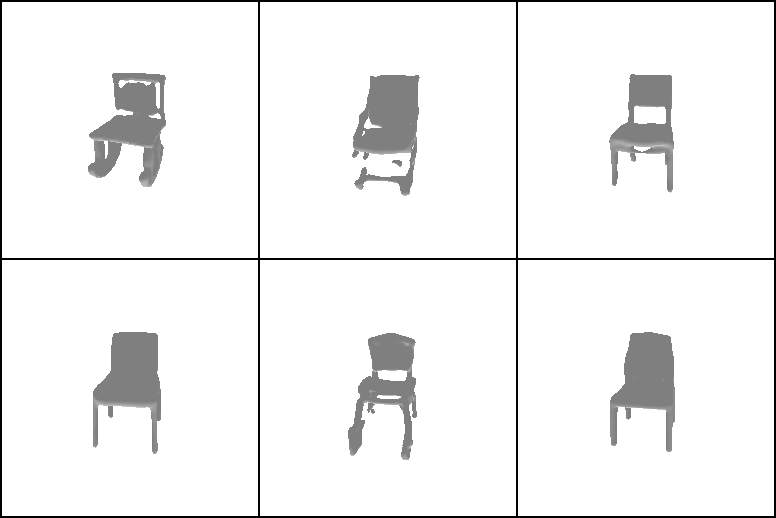

 48%|███████████████████████████████▏                                 | 24/50 [02:33<02:46,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-24-0-with slotted dowel backrest.gif
with slotted dowel backrest


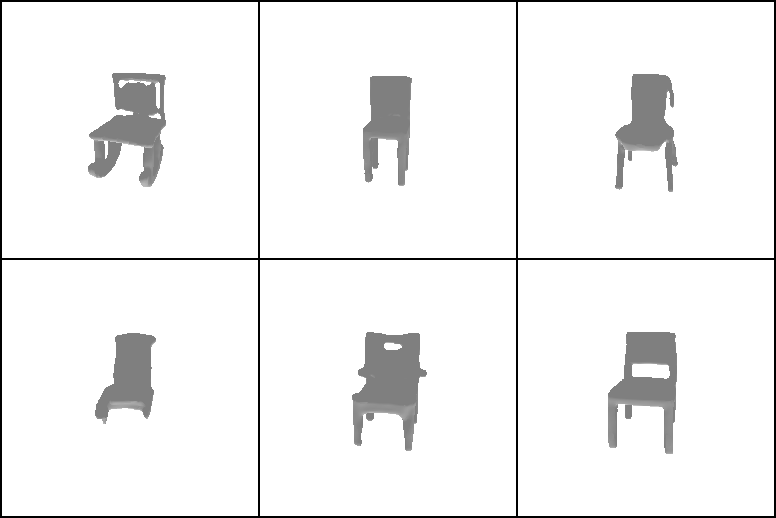

 50%|████████████████████████████████▌                                | 25/50 [02:40<02:40,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/25-1-No armrests.gif
No armrests


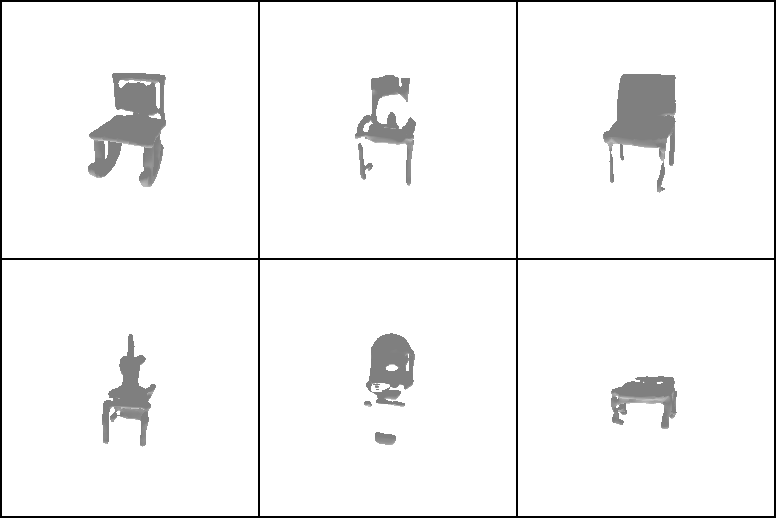

 52%|█████████████████████████████████▊                               | 26/50 [02:46<02:33,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-26-0-No armrests ..gif
No armrests .


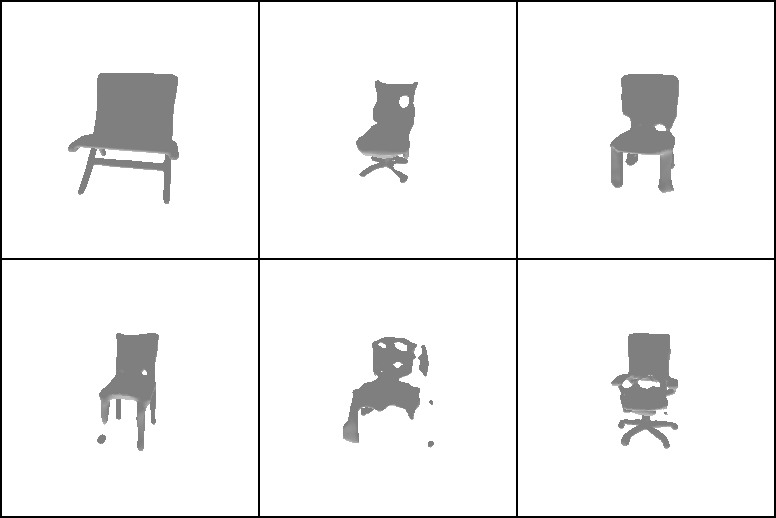

 54%|███████████████████████████████████                              | 27/50 [02:53<02:27,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-27-0-Beige wooden rocking chair.gif
Beige wooden rocking chair


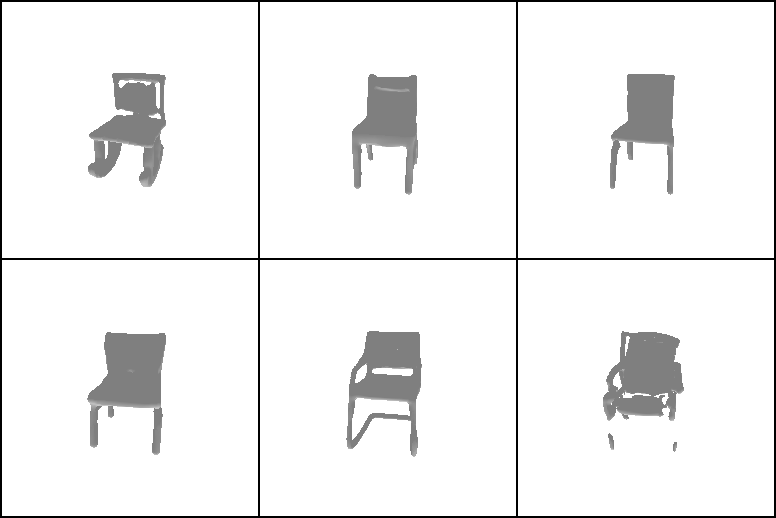

 56%|████████████████████████████████████▍                            | 28/50 [02:59<02:20,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/28-1-with slotted dowel backrest.gif
with slotted dowel backrest


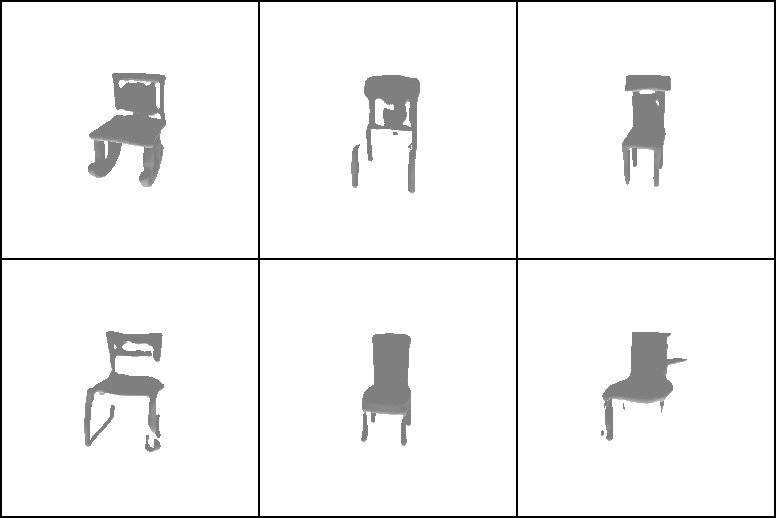

 58%|█████████████████████████████████████▋                           | 29/50 [03:05<02:14,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-29-0-A small sofa.gif
A small sofa


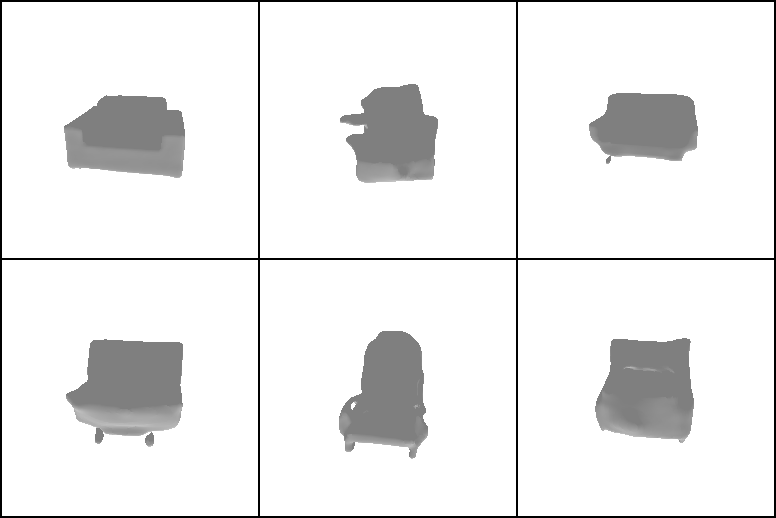

 60%|███████████████████████████████████████                          | 30/50 [03:12<02:08,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-30-0-with 4 legs.gif
with 4 legs


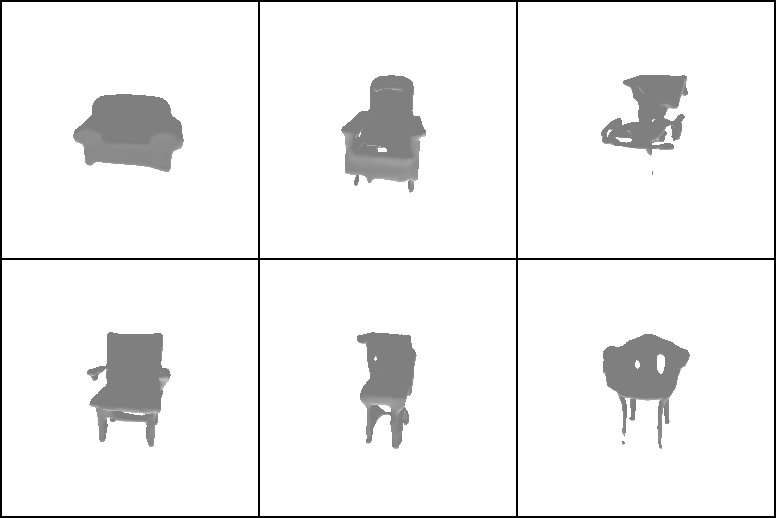

 62%|████████████████████████████████████████▎                        | 31/50 [03:18<02:02,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/31-1-and 2 cushion arm rests.gif
and 2 cushion arm rests


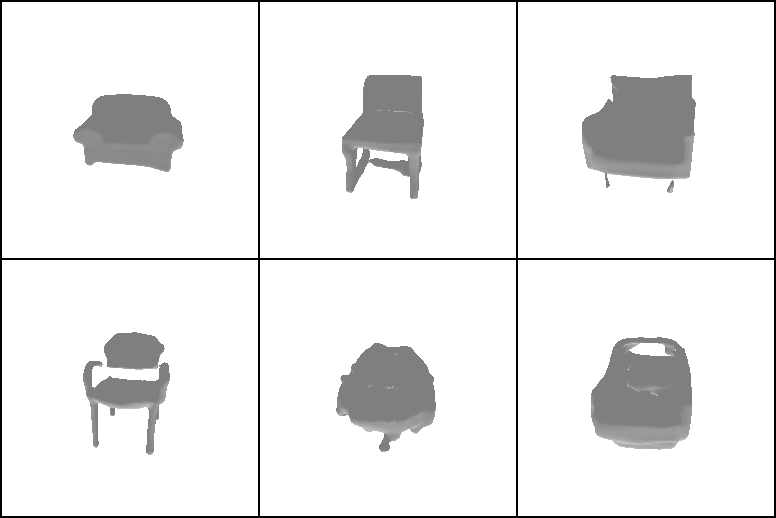

 64%|█████████████████████████████████████████▌                       | 32/50 [03:25<01:55,  6.44s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-32-0-A brown - green sofa.gif
A brown - green sofa


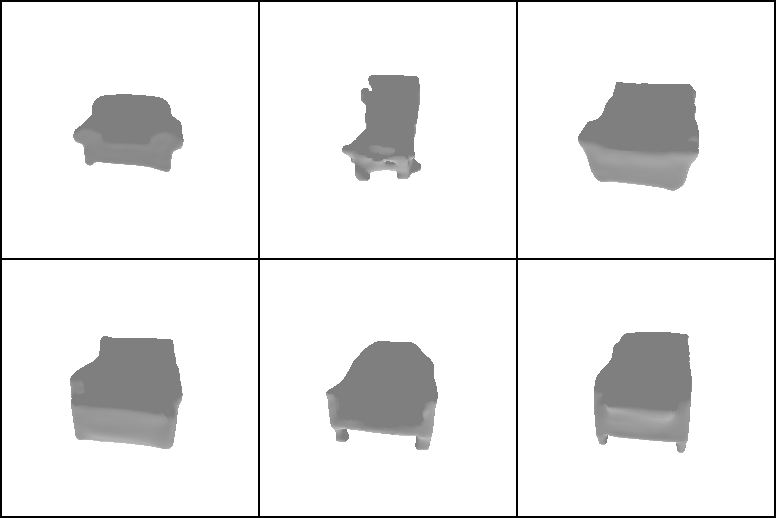

 66%|██████████████████████████████████████████▉                      | 33/50 [03:31<01:49,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-33-0-with large rounded armrests.gif
with large rounded armrests


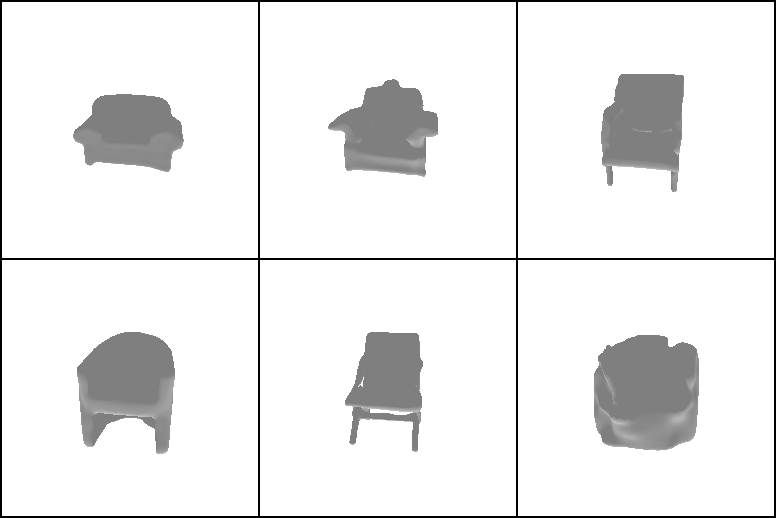

 68%|████████████████████████████████████████████▏                    | 34/50 [03:38<01:42,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/34-1-and a rounded backing.gif
and a rounded backing


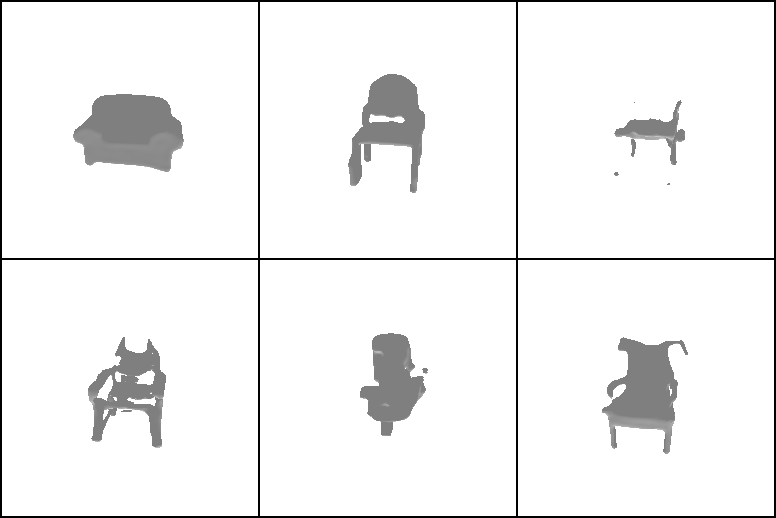

 70%|█████████████████████████████████████████████▌                   | 35/50 [03:44<01:36,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/35-2-A brown  green sofa with large rounded armrests and a rounded backing on the sofa.gif
A brown  green sofa with large rounded armrests and a rounded backing on the sofa


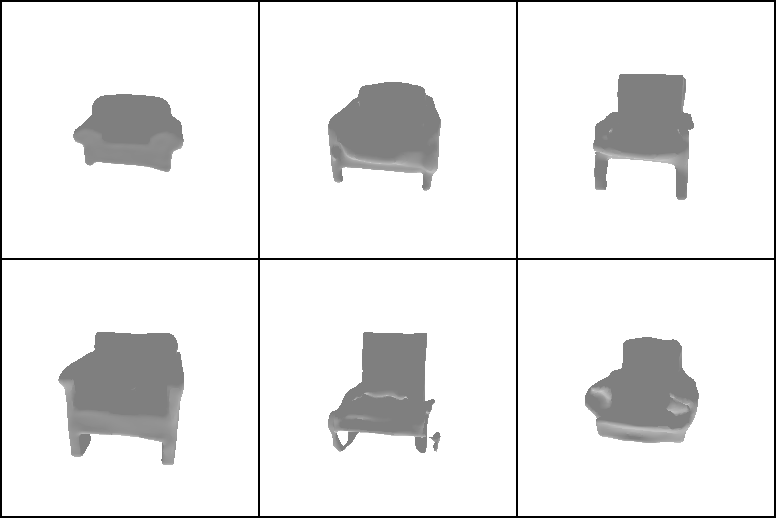

 72%|██████████████████████████████████████████████▊                  | 36/50 [03:50<01:30,  6.44s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-36-0-short leg brown colour cushion sofa.gif
short leg brown colour cushion sofa


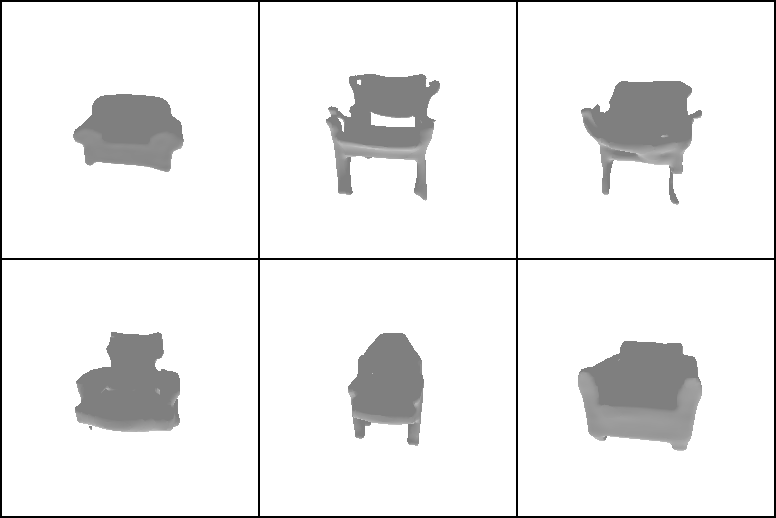

 74%|████████████████████████████████████████████████                 | 37/50 [03:57<01:23,  6.45s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-37-0-with handle.gif
with handle


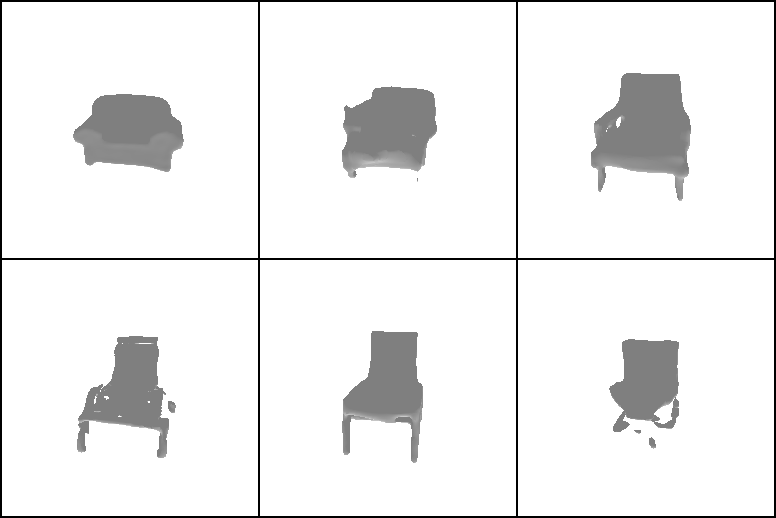

 76%|█████████████████████████████████████████████████▍               | 38/50 [04:03<01:17,  6.44s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/38-1-and comfort.gif
and comfort


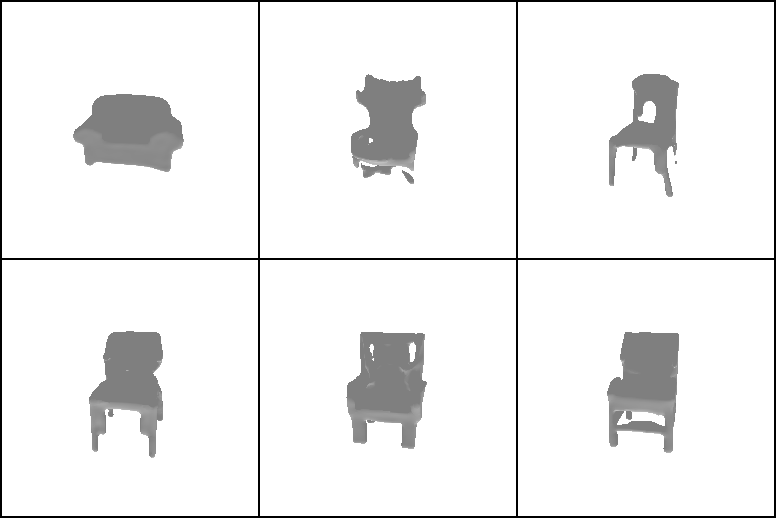

 78%|██████████████████████████████████████████████████▋              | 39/50 [04:10<01:10,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-39-0-The arms , back , and seat.gif
The arms , back , and seat


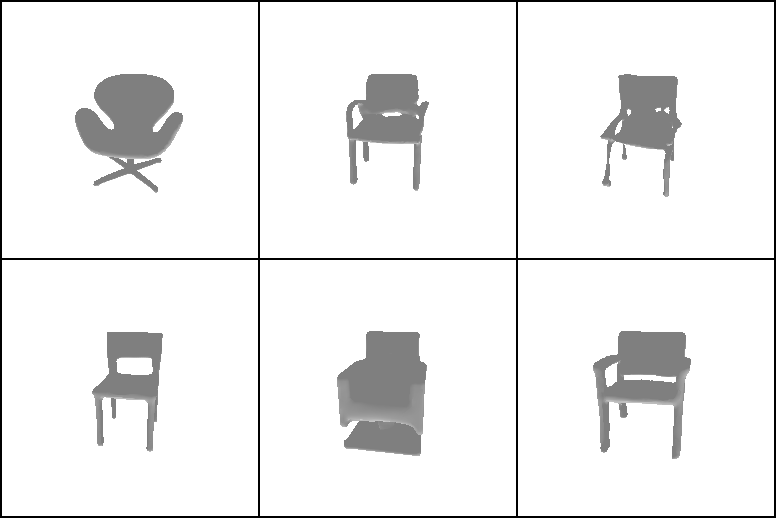

 80%|████████████████████████████████████████████████████             | 40/50 [04:16<01:04,  6.43s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-40-0-will be covered in leather or faux leather.gif
will be covered in leather or faux leather


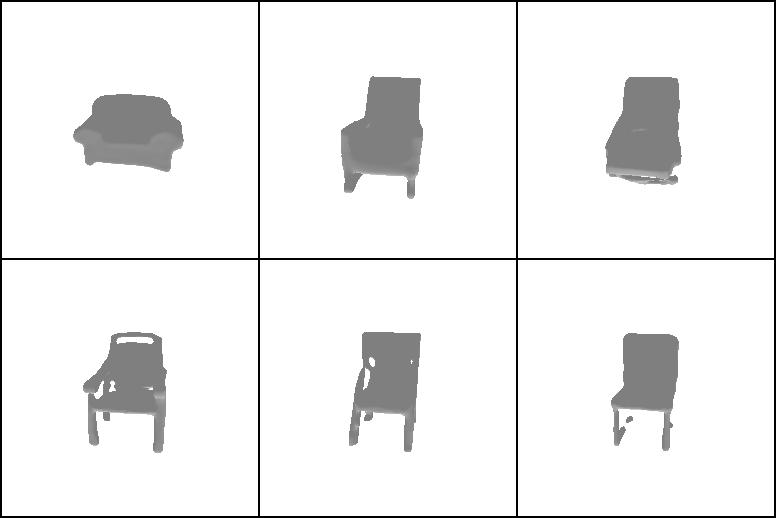

 82%|█████████████████████████████████████████████████████▎           | 41/50 [04:23<00:57,  6.42s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/41-1-This chair  too.gif
This chair  too


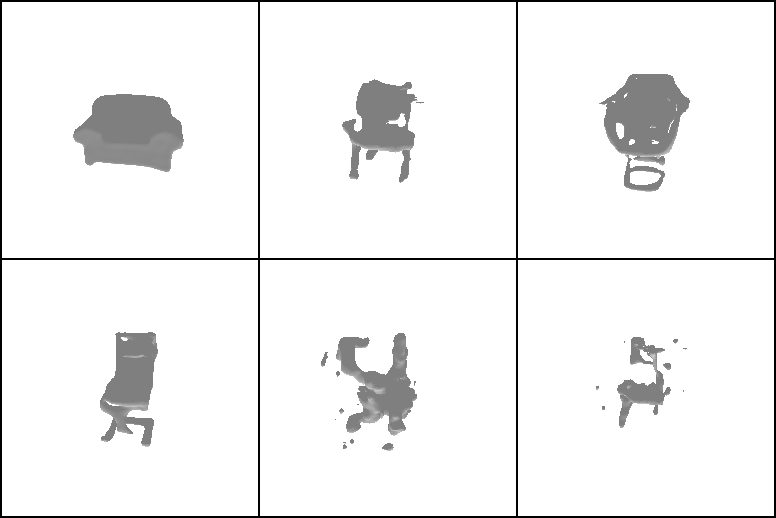

 84%|██████████████████████████████████████████████████████▌          | 42/50 [04:29<00:51,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/42-2-may have loose or tight cushions.gif
may have loose or tight cushions


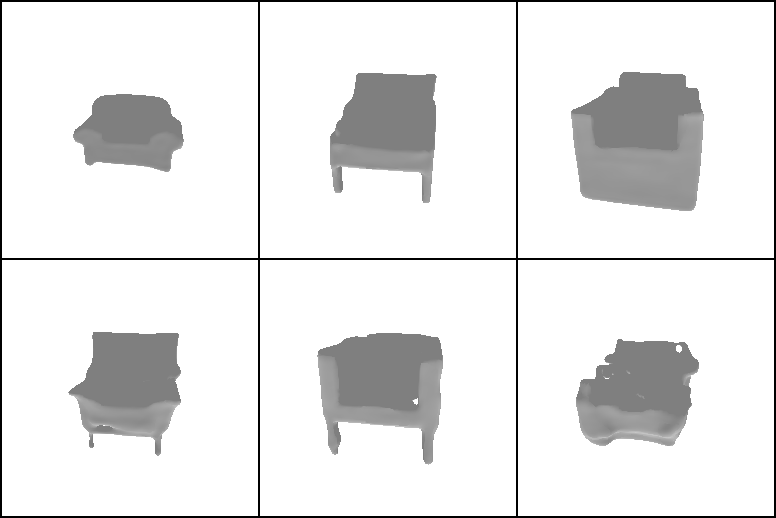

 86%|███████████████████████████████████████████████████████▉         | 43/50 [04:35<00:44,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-43-0-This chair , too ,.gif
This chair , too ,


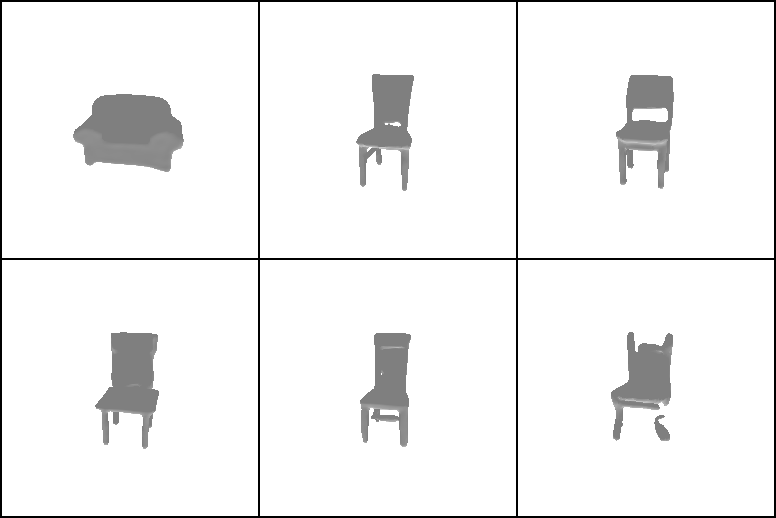

 88%|█████████████████████████████████████████████████████████▏       | 44/50 [04:42<00:38,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/44-1-The arms  back  and seat.gif
The arms  back  and seat


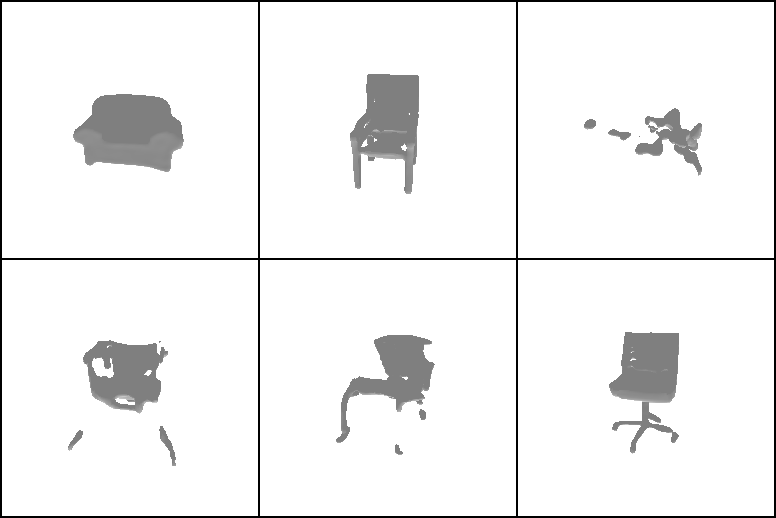

 90%|██████████████████████████████████████████████████████████▌      | 45/50 [04:48<00:31,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-45-0-Grey colored soft materialized chair.gif
Grey colored soft materialized chair


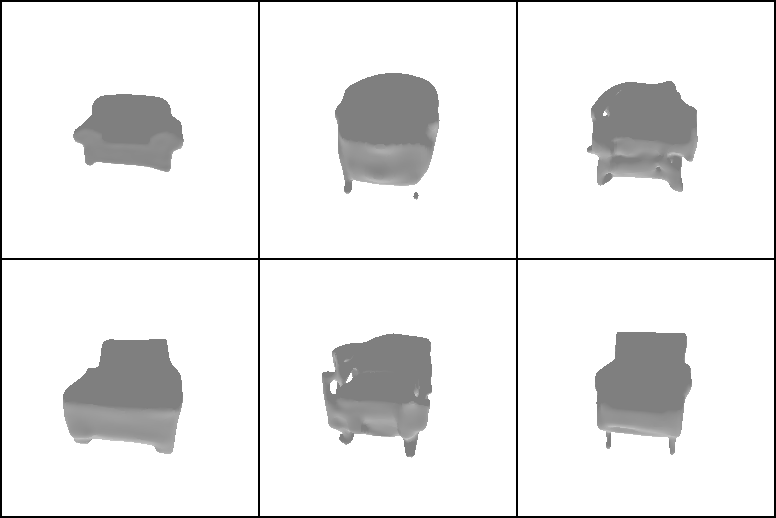

 92%|███████████████████████████████████████████████████████████▊     | 46/50 [04:55<00:25,  6.40s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-46-0-with armrest.gif
with armrest


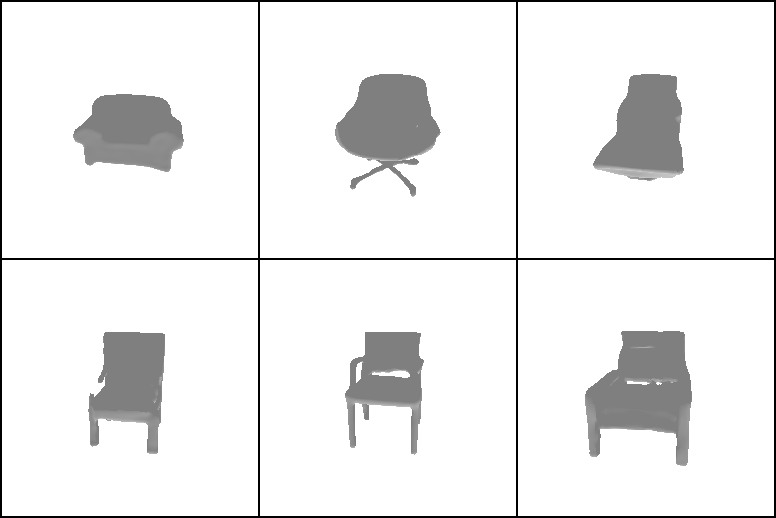

 94%|█████████████████████████████████████████████████████████████    | 47/50 [05:01<00:19,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-47-0-This is a metal chair ..gif
This is a metal chair .


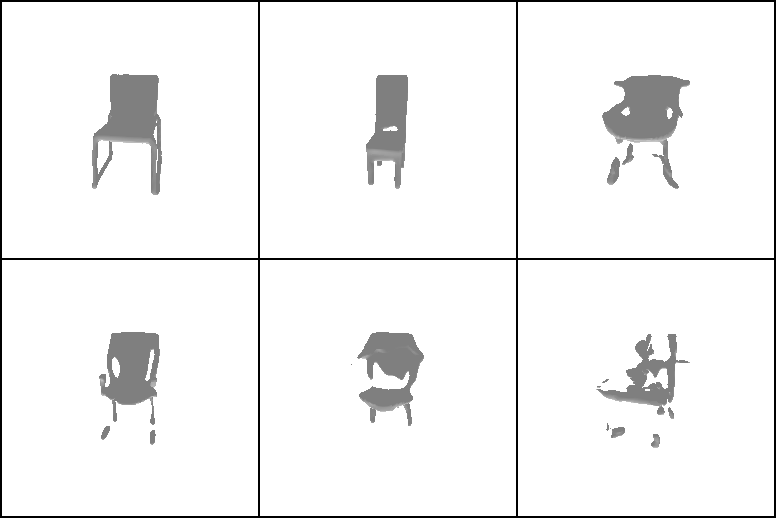

 96%|██████████████████████████████████████████████████████████████▍  | 48/50 [05:07<00:12,  6.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/START-48-0-It.gif
It


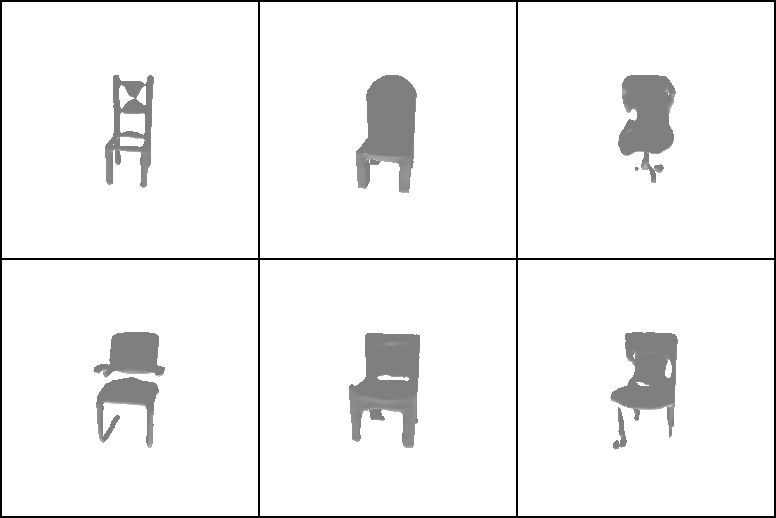

 98%|███████████████████████████████████████████████████████████████▋ | 49/50 [05:14<00:06,  6.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved:logs/july-12/t3-withprobs/49-1-is low to the ground.gif
is low to the ground


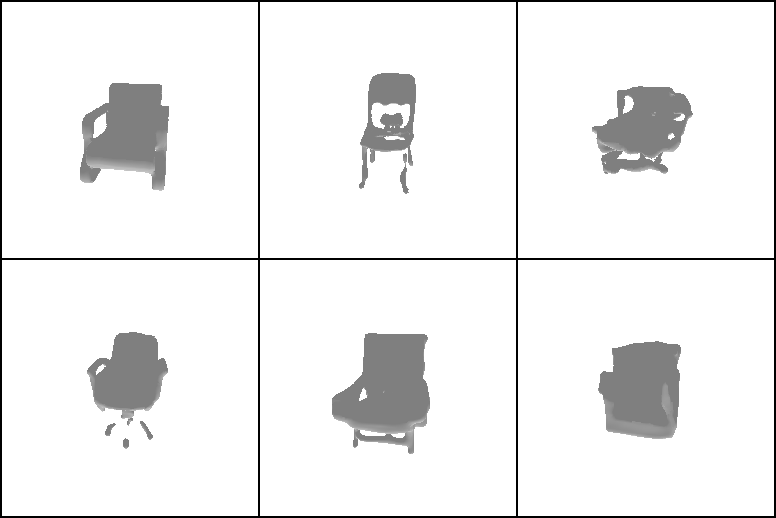

100%|█████████████████████████████████████████████████████████████████| 50/50 [05:20<00:00,  6.41s/it]


In [11]:
import torch
from utils.qual_util import save_mesh_as_pics
from einops import rearrange
seed_everything(250)
model = modelV5
trans_name = "transV5"
bert_name = "bertV9"
bert2vq = bert2vqV9
sf = torch.nn.Softmax(dim=-1)
lgsf = torch.nn.LogSoftmax(dim=-1)
nimgs=5
topk=5
step_counter = 0
z1 = torch.full((nimgs,8,8,8,512),1/512).cuda()
for j in tqdm(range(50)):
       test_data = {}
       #k = np.random.randint(1000)
       k=j
       data = dataset[k]
       current_text = data["current_text"]
       is_reset = data["is_reset"]
       start = ""
       target = data["z_set_target"].cuda()
       #shape = data["z_shape"].cuda()
       if(is_reset):
         z1 = torch.full((nimgs,8,8,8,512),1/512).cuda()
         step_counter = 0
         start = "START-"
       prob_conditional = bert2vq([current_text] * nimgs, z1.float())
       logged = lgsf(prob_conditional)
       prob_conditional = sf(prob_conditional)
       test_data["z_set"] = torch.full((nimgs,8,8,8,512),1/512).cuda()
       sampler = torch.distributions.categorical.Categorical(z1)
       test_data["idx"] = torch.cat( [sampler.sample().cpu()], dim=0)
       model.inference(test_data, topk=topk, alpha=0.5, prob=logged, gen_order=None)
       z1 = model.outp_concat
       #gen_mesh = sdf_to_mesh(model.x_recon_tf)
       target_img = model.vqvae.decode_enc_idices(target.unsqueeze(0).flatten(start_dim=1), z_spatial_dim=8).to(target.device)
       #tgt_shape =  model.vqvae.decode_enc_idices(shape.unsqueeze(0).flatten(start_dim=1), z_spatial_dim=8).to(target.device)
       #gen_target = sdf_to_mesh(target_img)
       a = torch.cat([target_img,model.x_recon_tf],dim=0)
       gen_target = sdf_to_mesh(a)
       saved_name = f"{res_dir}/{start}{j}-{step_counter}-{current_text}.gif"
       step_counter +=1
       save_mesh_as_pics(mesh_renderer, gen_target, nrow=3, out_name=saved_name)
       cprint(f"Saved:{saved_name}","cyan")
       cprint(current_text,"cyan")
       display(ipy_image(saved_name))

